In [1]:
import model
import numpy as np
import random
import tank
import truck

import gym_pdsystem

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
import matplotlib.patches as mpatches

from IPython.display import HTML

import pandas as pd
import time

from gym_pdsystem.envs.pdsystem_env import PDSystemEnv
import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct
import gym_pdsystem.utils.functions as fnc

import os

simulations_directory = './simulations'
if not os.path.exists(simulations_directory):
    os.makedirs(simulations_directory)


In [2]:
COEFF = ct.COEFF

C_TRANSPORT = ct.C_TRANSPORT
C_LEVELS = ct.C_LEVELS

p0_GLOBAL = ct.p0_GLOBAL

P1_GLOBAL = ct.P1_GLOBAL
P2_GLOBAL = ct.P2_GLOBAL

M_GLOBAL = ct.M_GLOBAL

NOT_DELIVERYING_PENALTY = ct.NOT_DELIVERYING_PENALTY 

## System initializer

In [3]:
def initialize_test_system(noise = False, seed = None):
    if seed != None:
        np.random.seed(seed)

    # Tanks' information
    global n
    n = 5 
    tank_ids = list(range(1,n+1))
    tank_max_loads =  np.array([100., 200, 100., 800., 200.])
    C_max = np.array([ [load] for load in tank_max_loads ])

    tank_current_loads = np.full(n,0)
    tank_consumption_rates =  np.array([5.] * n)
    noisy_consumption_rate = noise
    
    global n_discrete_load_levels
    n_discrete_load_levels = np.array([4,4,4,4,4])
    
    load_level_percentages = np.array([ #b , c, e
                                            [0.02, 0.31, 0.9],
                                            [0.01, 0.03, 0.9],
                                            [0.05, 0.16, 0.9],
                                            [0.07, 0.14, 0.85],
                                            [0.08, 0.26, 0.9]
                                               ])
    for i in range(n):
        tank_consumption_rates[i] = tank_max_loads[i] * (load_level_percentages[i][0] + load_level_percentages[i][1])/2.0
        
    tank_levels = np.multiply(C_max,load_level_percentages)
    
    for i, tank_level in enumerate(tank_levels):
                a = tank_level[0]
                b = tank_level[-1]
                #current_load = 0.75 * (a+b)/2.0# np.random.randint(a+1,b, size =(1,)) GIVES A STRANGE ERROR
                current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)
                tank_current_loads[i] = current_load * 1.0
                
    # Trucks' information
    global k
    k = 2
    truck_ids = list(range(k))
    truck_max_loads = np.array([70.,130.])
    truck_current_loads = truck_max_loads.copy()
    truck_current_positions =  np.array([5] * k)
    #truck_fractions_deliverable =  np.array([1.] * k) # we for now we only allow to deliver all the content of the truck
    truck_fractions_deliverable =  np.array([ np.array([1.]), 
                                              np.array([1.])
                                            ]) # we for now we only allow to deliver all the content of the truck
    global n_discrete_load_levels_trucks
    n_discrete_load_levels_trucks = np.array([1,1])

    # System's information
   
    graph = ut.simple_graph(n+1)
    tanks = [tank.Tank( tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls, noisy_consumption_rate) 
             for  tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls in 
             zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates, n_discrete_load_levels,
                  load_level_percentages)]
    trucks = [truck.Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls) 
             for  truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls in 
             zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
                 truck_fractions_deliverable, n_discrete_load_levels_trucks)]

    w =  np.array([32., 159., 162., 156.,156., 0.])

    weights_matrix = ut.simple_weights(n+1, w)
    
    return(tanks, trucks, graph, weights_matrix)

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

# Action-State space dimension
print("States space dimension: ",toy_system.states_dim)
print("Actions space dimension: ",toy_system.actions_dim)
a_s_dim = toy_system.states_dim * toy_system.actions_dim
print("States-Actions space dimension: ",a_s_dim)

States space dimension:  36864
Actions space dimension:  36
States-Actions space dimension:  1327104


In [4]:
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)
print("Tank max loads: ",system.tank_max_loads())
print("Tank dayly rates: ",system.tank_rates())
print("Truck max loads: ",system.truck_max_loads())
print("Graph: \n",system.graph)
print("Weights: \n", system.weights)

Tank max loads:  [100.0, 200.0, 100.0, 800.0, 200.0]
Tank dayly rates:  [16.5, 4.0, 10.500000000000002, 84.00000000000001, 34.0]
Truck max loads:  [70.0, 130.0]
Graph: 
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 1]]
Weights: 
 [[ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ 32. 159. 162. 156. 156.   0.]]


### Reinitialize system function

In [5]:
def reinitialize_system(system, seed = None):
    if seed != None:
        np.random.seed(seed)
        
    for tank, tank_levels in zip(system.tanks, system.tanks_level):
        a = tank_levels[0]
        b = tank_levels[-1]
        current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)*1.0
        tank.load = current_load
    system.reset_trucks_positions(); 
    return(system)    

## Q-learning algorithm (off-policy)


### Training

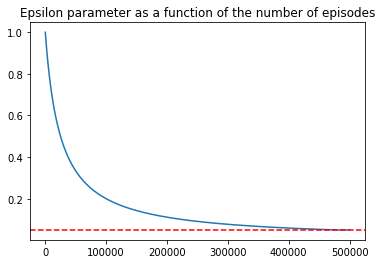

In [6]:
# Retrain parameters:
retrain = False

episode_retrain = 2*10**3 # episode number from which start the retrain. Ensure that a file with this number in 
                          # the Q filename is available.
retrain_episodes = 1*10**3


# Train parameters:
train_epsilon = True

learning_rate0 = 1 
learning_rate_decay = 0 

episode_length = 30
discount_rate = 0.9

episodes = 5*10**5
episodes_epsilon_min = 0.05*episodes

# Output's frequencies
train_freq = 10**2 # 10**4
train_vis_freq =  np.inf #10**3
train_rew_freq =  10**2
train_Q_freq =  10**3 #3

epsilon0 = 1.0
epsilon_decay =( 1./(episodes_epsilon_min) ) 
epsilon_min = 0.05

verbose = False
verbose_info = False

seed = 42

simulation_id = 227
add_noise = True

# Visualization of the epsilon parameter value that will be present duing the simulation
% matplotlib inline

def epsilon_fnc(x, epsilon0 = epsilon0, decay = epsilon_decay, epsilon_min = epsilon_min):
    e_mins = epsilon_min * np.ones(len(x))
    eps = epsilon0 / (1.0 + (x-1)*epsilon_decay)
    return np.maximum(e_mins, eps )

t = np.arange(1, episodes, 1)
epsilon = epsilon_fnc(t)

plt.plot(t, epsilon)
plt.axhline(y= epsilon_min, xmin=0, xmax=episodes, hold=None, color = "Red", linestyle = '--')

plt.title("Epsilon parameter as a function of the number of episodes");

In [7]:
train_visualization_steps = []
train_rewards_list = []

tanks, trucks, graph, weights_matrix = initialize_test_system(noise = add_noise, seed = seed)
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = {}

if train_epsilon == False and retrain == False:
     pass
else: # Create directories for the simulations' outputs

    simulation_directory = './simulations/simulation{}'.format(simulation_id)
    rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
    states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing

    if not os.path.exists(simulation_directory):
        os.makedirs(simulation_directory)
        os.makedirs(simulation_directory + '/Q-dictionaries')
        os.makedirs(simulation_directory + '/discrewards')
        os.makedirs(simulation_directory + '/vis')

    else:
        raise Exception("The simulation id you tried to use has been already used before. Try to change it to a new one.")


    ut.save_obj(toy_system, simulation_directory+"/system-sim"+"{}".format(simulation_id)) 

    # Output headers to file
    with open(rewards_file,'w') as f:
         np.savetxt(f, [["episode", "discreward"]], fmt="%s", delimiter=',')         


Exception: The simulation id you tried to use has been already used before. Try to change it to a new one.

In [8]:
def episodic_train_Q_epsilon( 
            epsilon0 = epsilon0,
            epsilon_min = epsilon_min,
            n_episodes = episodes, 
            episode_length = episode_length,
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            vis_freq = train_vis_freq,
            rew_freq = train_rew_freq,
            Q_freq = train_Q_freq,
            simulation_id = simulation_id,
            round_time = 2
    
           ):
    
    time_start = time.time()
    
    for episode in range(1,n_episodes+1):
        print("\rEpisode: {}".format(episode), end="")

        reinitialize_system(system, seed = episode)
        
        ### epsilon-greedy exploration
        epsilon = max( epsilon_min, epsilon0 / (1+(episode-1)*epsilon_decay) ) 
        
        ### decrement of learning rate
        learning_rate = learning_rate0 / (1+(episode-1)*learning_rate_decay)        

        discounted_reward = 0
        
        for t in range(episode_length):

            system.update_state()
            s_current = system.state_to_string()                
            p = np.random.uniform()

            if p > epsilon:
                #DETERMINISTIC ACTION OPTIMAL
                s0 = system.state_to_string()
                best_action = optimal_policy(s0, Q)
                if best_action == None:
                    reward, _,_,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)
                else:
                    reward, _ ,_,_ = system.deterministic_action(best_action)
                #print(best_action)
            else:
                reward,_ ,_,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)

            a_current = system.action_to_string()
            sa_current = ''.join([s_current, a_current])

            system.update_state()
            sa_new = system.state_action_to_string()

            if ut.is_key(Q, sa_current) == False:
                Q[sa_current] = 0

            Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_new[0:system.state_length])]+[0.0]) 

            if Q[sa_current] != -np.inf:
                Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                                 + learning_rate* (reward + discount_rate * Q_max)
                                )
                
            discounted_reward = discounted_reward + (discount_rate**t) * reward
            system.reset_trucks_positions();     
            system.reset_trucks_loads();
            
        #rewards_list.append(discounted_reward);
        if episode % freq == 0:
                time_end = time.time()
                print(". Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.",
                      "epsilon", round(epsilon,4), 
                     "Discounted reward: ", discounted_reward)
                
                if verbose_info:
                    print("s, a", system.s, system.a)
                    print("ds, da", system.ds, system.da)
        if episode % Q_freq == 0:           
                ut.save_obj(Q, simulation_directory +"/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode))   

        if episode % vis_freq == 0:
                #Save visualization and rewards
                visualization_steps.append(toy_system.visualize());
                ut.save_obj(visualization_steps, simulation_directory +"/vis/vis-train-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode))   
                                
        if episode % rew_freq == 0:
                #rewards_list.append(discounted_reward);
                #ut.save_obj(rewards_list, simulation_directory +"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")
                # Output data to files
                with open(rewards_file,'ab') as f:
                    np.savetxt(f, [np.array([episode, discounted_reward])], fmt=("%d",'%.10f'), delimiter=',')    
        
    end_time = round(time.time()-time_start,round_time)        
    print("Training finished. Total episodes: {}. Elapsed time: {} minutes.".format(n_episodes,round(end_time/60., round_time)))        

In [9]:
# Given a state, returns the action that has the highest Q-value.

def optimal_policy(state, Q, system = toy_system):
    """
    state must be in the string-integers code
    """
    state_keys = [key for key in list(Q) if key.startswith(state)]
    if len(state_keys) == 0:
        return(None)
    
    state_q = [Q[state_key] for state_key in state_keys]
    
    #print("state_q ", state_q[1:min(10,len(state_q))])
    
    max_q = max(state_q)
    #print("max_q", max_q)
    optimal_key_index = np.where(np.isin(state_q, max_q ))[0][0]
    #print("optimal_key_index", optimal_key_index)
    optimal_key = state_keys[optimal_key_index]
    #print("optimal_key", optimal_key)
    optimal_action = optimal_key[system.state_length:]
    
    return(optimal_action)
    

In [10]:
# if train_epsilon == False and retrain == False:
#     pass
# elif train_epsilon == True and retrain == False:
#     episodic_train_Q_epsilon()
# elif train_epsilon == False and retrain == True:
#     Q_retrain = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode_retrain))
#     episodic_train_Q_epsilon(n_episodes = retrain_episodes, Q = Q_retrain)
# else:
#     raise Exception("Only one of the parameters train_epsilon or retrain parameters can be set to True.")
    

Episode: 100. Elapsed time  0.08  minuts. epsilon 0.9961 Discounted reward:  -19.295292724305376
Episode: 200. Elapsed time  0.2  minuts. epsilon 0.9921 Discounted reward:  -19.89264481237216
Episode: 300. Elapsed time  0.32  minuts. epsilon 0.9882 Discounted reward:  -18.953324163100756
Episode: 400. Elapsed time  0.47  minuts. epsilon 0.9843 Discounted reward:  -14.962932475386589
Episode: 500. Elapsed time  0.65  minuts. epsilon 0.9804 Discounted reward:  -21.606086390960133
Episode: 600. Elapsed time  0.82  minuts. epsilon 0.9766 Discounted reward:  -22.582241683281318
Episode: 700. Elapsed time  1.02  minuts. epsilon 0.9728 Discounted reward:  -23.07982059053499
Episode: 800. Elapsed time  1.25  minuts. epsilon 0.969 Discounted reward:  -14.775707050508219
Episode: 900. Elapsed time  1.49  minuts. epsilon 0.9653 Discounted reward:  -16.044212157132208
Episode: 1000. Elapsed time  1.73  minuts. epsilon 0.9616 Discounted reward:  -22.109775190329966
Episode: 1100. Elapsed time  1.98

Episode: 8500. Elapsed time  38.53  minuts. epsilon 0.7463 Discounted reward:  -16.60578375982834
Episode: 8600. Elapsed time  39.17  minuts. epsilon 0.7441 Discounted reward:  -12.142245631027727
Episode: 8700. Elapsed time  39.82  minuts. epsilon 0.7419 Discounted reward:  -14.144315893689788
Episode: 8800. Elapsed time  40.45  minuts. epsilon 0.7397 Discounted reward:  -14.907032486690794
Episode: 8900. Elapsed time  41.1  minuts. epsilon 0.7375 Discounted reward:  -12.644408183635827
Episode: 9000. Elapsed time  41.77  minuts. epsilon 0.7353 Discounted reward:  -17.16639766642152
Episode: 9100. Elapsed time  42.43  minuts. epsilon 0.7332 Discounted reward:  -16.69137985810791
Episode: 9200. Elapsed time  43.07  minuts. epsilon 0.731 Discounted reward:  -20.148197775724153
Episode: 9300. Elapsed time  43.71  minuts. epsilon 0.7289 Discounted reward:  -9.577468915631197
Episode: 9400. Elapsed time  44.36  minuts. epsilon 0.7268 Discounted reward:  -10.296766591413515
Episode: 9500. E

Episode: 16800. Elapsed time  97.12  minuts. epsilon 0.5981 Discounted reward:  -8.271468891836129
Episode: 16900. Elapsed time  97.86  minuts. epsilon 0.5967 Discounted reward:  -12.06090835282933
Episode: 17000. Elapsed time  98.59  minuts. epsilon 0.5953 Discounted reward:  -13.67466178669659
Episode: 17100. Elapsed time  99.31  minuts. epsilon 0.5938 Discounted reward:  -12.885976049607914
Episode: 17200. Elapsed time  100.08  minuts. epsilon 0.5924 Discounted reward:  -15.4684148800285
Episode: 17300. Elapsed time  100.8  minuts. epsilon 0.591 Discounted reward:  -14.55461511627896
Episode: 17400. Elapsed time  101.55  minuts. epsilon 0.5896 Discounted reward:  -11.549174279377027
Episode: 17500. Elapsed time  102.29  minuts. epsilon 0.5882 Discounted reward:  -15.650814231548988
Episode: 17600. Elapsed time  103.04  minuts. epsilon 0.5869 Discounted reward:  -5.644373559325761
Episode: 17700. Elapsed time  103.86  minuts. epsilon 0.5855 Discounted reward:  -10.581856478953323
Epi

Episode: 25000. Elapsed time  175.37  minuts. epsilon 0.5 Discounted reward:  -10.57070955058593
Episode: 25100. Elapsed time  176.26  minuts. epsilon 0.499 Discounted reward:  -16.113064364718056
Episode: 25200. Elapsed time  177.49  minuts. epsilon 0.498 Discounted reward:  -7.811961112896161
Episode: 25300. Elapsed time  178.42  minuts. epsilon 0.497 Discounted reward:  -8.887496906195778
Episode: 25400. Elapsed time  179.35  minuts. epsilon 0.496 Discounted reward:  -6.462003354557318
Episode: 25500. Elapsed time  180.29  minuts. epsilon 0.4951 Discounted reward:  -11.617368912833914
Episode: 25600. Elapsed time  181.22  minuts. epsilon 0.4941 Discounted reward:  -15.391456060661687
Episode: 25700. Elapsed time  182.17  minuts. epsilon 0.4931 Discounted reward:  -5.365340543991316
Episode: 25800. Elapsed time  183.11  minuts. epsilon 0.4921 Discounted reward:  -6.817917236786148
Episode: 25900. Elapsed time  184.05  minuts. epsilon 0.4912 Discounted reward:  -10.690055314592405
Epi

Episode: 33200. Elapsed time  279.62  minuts. epsilon 0.4296 Discounted reward:  -5.371172170731251
Episode: 33300. Elapsed time  280.61  minuts. epsilon 0.4288 Discounted reward:  -8.405962129709858
Episode: 33400. Elapsed time  281.6  minuts. epsilon 0.4281 Discounted reward:  -4.2860722781351095
Episode: 33500. Elapsed time  282.6  minuts. epsilon 0.4274 Discounted reward:  -8.714890885841271
Episode: 33600. Elapsed time  283.59  minuts. epsilon 0.4266 Discounted reward:  -11.05655050704411
Episode: 33700. Elapsed time  284.61  minuts. epsilon 0.4259 Discounted reward:  -6.374347798166055
Episode: 33800. Elapsed time  285.61  minuts. epsilon 0.4252 Discounted reward:  -7.376183611395406
Episode: 33900. Elapsed time  286.6  minuts. epsilon 0.4245 Discounted reward:  -8.755502438714807
Episode: 34000. Elapsed time  287.61  minuts. epsilon 0.4237 Discounted reward:  -6.253073743413697
Episode: 34100. Elapsed time  288.65  minuts. epsilon 0.423 Discounted reward:  -5.789442625566319
Epi

Episode: 41400. Elapsed time  366.16  minuts. epsilon 0.3765 Discounted reward:  -5.3535355521624055
Episode: 41500. Elapsed time  367.32  minuts. epsilon 0.3759 Discounted reward:  -9.11251188416593
Episode: 41600. Elapsed time  368.41  minuts. epsilon 0.3754 Discounted reward:  -7.044251387058244
Episode: 41700. Elapsed time  369.57  minuts. epsilon 0.3748 Discounted reward:  -3.0717180352149125
Episode: 41800. Elapsed time  371.06  minuts. epsilon 0.3743 Discounted reward:  -5.943940680677653
Episode: 41900. Elapsed time  372.2  minuts. epsilon 0.3737 Discounted reward:  -3.907913444687981
Episode: 42000. Elapsed time  373.34  minuts. epsilon 0.3731 Discounted reward:  -6.878467415928084
Episode: 42100. Elapsed time  374.49  minuts. epsilon 0.3726 Discounted reward:  -5.997530857849902
Episode: 42200. Elapsed time  375.6  minuts. epsilon 0.372 Discounted reward:  -8.384549792260064
Episode: 42300. Elapsed time  376.76  minuts. epsilon 0.3715 Discounted reward:  -8.520784530586333
Ep

Episode: 49600. Elapsed time  482.49  minuts. epsilon 0.3351 Discounted reward:  -3.7992181652129067
Episode: 49700. Elapsed time  483.63  minuts. epsilon 0.3347 Discounted reward:  -7.666615621103059
Episode: 49800. Elapsed time  484.8  minuts. epsilon 0.3342 Discounted reward:  -6.690999704250756
Episode: 49900. Elapsed time  485.92  minuts. epsilon 0.3338 Discounted reward:  -6.856929522387076
Episode: 50000. Elapsed time  487.1  minuts. epsilon 0.3333 Discounted reward:  -10.572785358535503
Episode: 50100. Elapsed time  488.29  minuts. epsilon 0.3329 Discounted reward:  -5.005685573022418
Episode: 50200. Elapsed time  489.47  minuts. epsilon 0.3325 Discounted reward:  -4.552933872674845
Episode: 50300. Elapsed time  490.62  minuts. epsilon 0.332 Discounted reward:  -10.52602935759855
Episode: 50400. Elapsed time  491.79  minuts. epsilon 0.3316 Discounted reward:  -8.358638742378648
Episode: 50500. Elapsed time  492.96  minuts. epsilon 0.3311 Discounted reward:  -9.055523864358824
E

Episode: 57800. Elapsed time  588.85  minuts. epsilon 0.3019 Discounted reward:  -3.899774987909599
Episode: 57900. Elapsed time  589.95  minuts. epsilon 0.3016 Discounted reward:  -6.1350186513592835
Episode: 58000. Elapsed time  591.03  minuts. epsilon 0.3012 Discounted reward:  -5.004336816650991
Episode: 58100. Elapsed time  592.12  minuts. epsilon 0.3008 Discounted reward:  -4.71338870737448
Episode: 58200. Elapsed time  593.2  minuts. epsilon 0.3005 Discounted reward:  -10.152180811897527
Episode: 58300. Elapsed time  594.25  minuts. epsilon 0.3001 Discounted reward:  -6.317353594701699
Episode: 58400. Elapsed time  595.32  minuts. epsilon 0.2998 Discounted reward:  -3.8561170674176424
Episode: 58500. Elapsed time  596.42  minuts. epsilon 0.2994 Discounted reward:  -11.896723919084966
Episode: 58600. Elapsed time  597.53  minuts. epsilon 0.299 Discounted reward:  -3.5989226329750714
Episode: 58700. Elapsed time  598.62  minuts. epsilon 0.2987 Discounted reward:  -7.65696494984127

Episode: 66000. Elapsed time  678.86  minuts. epsilon 0.2747 Discounted reward:  -2.180942096183853
Episode: 66100. Elapsed time  680.01  minuts. epsilon 0.2744 Discounted reward:  -6.816597521468343
Episode: 66200. Elapsed time  681.1  minuts. epsilon 0.2741 Discounted reward:  -4.66250080210941
Episode: 66300. Elapsed time  682.24  minuts. epsilon 0.2738 Discounted reward:  -3.569196866692553
Episode: 66400. Elapsed time  683.35  minuts. epsilon 0.2735 Discounted reward:  -3.2409391735028925
Episode: 66500. Elapsed time  684.44  minuts. epsilon 0.2732 Discounted reward:  -4.202830343804768
Episode: 66600. Elapsed time  685.58  minuts. epsilon 0.2729 Discounted reward:  -4.96940701993682
Episode: 66700. Elapsed time  686.72  minuts. epsilon 0.2726 Discounted reward:  -2.681299318425798
Episode: 66800. Elapsed time  687.86  minuts. epsilon 0.2723 Discounted reward:  -4.277052282219547
Episode: 66900. Elapsed time  688.98  minuts. epsilon 0.272 Discounted reward:  -5.3667384185573495
Ep

Episode: 74200. Elapsed time  770.47  minuts. epsilon 0.252 Discounted reward:  -6.766113258613095
Episode: 74300. Elapsed time  771.53  minuts. epsilon 0.2518 Discounted reward:  -9.112328285391541
Episode: 74400. Elapsed time  772.63  minuts. epsilon 0.2515 Discounted reward:  -6.986258177104188
Episode: 74500. Elapsed time  773.81  minuts. epsilon 0.2513 Discounted reward:  -3.745658914766802
Episode: 74600. Elapsed time  775.11  minuts. epsilon 0.251 Discounted reward:  -4.785818038598233
Episode: 74700. Elapsed time  776.21  minuts. epsilon 0.2508 Discounted reward:  -3.4971217802299996
Episode: 74800. Elapsed time  777.32  minuts. epsilon 0.2505 Discounted reward:  -2.8974781785497226
Episode: 74900. Elapsed time  778.48  minuts. epsilon 0.2503 Discounted reward:  -5.086711810898342
Episode: 75000. Elapsed time  779.57  minuts. epsilon 0.25 Discounted reward:  -5.761521648921769
Episode: 75100. Elapsed time  780.69  minuts. epsilon 0.2498 Discounted reward:  -3.6796180082434695
E

Episode: 90600. Elapsed time  958.02  minuts. epsilon 0.2163 Discounted reward:  -5.881765941368304
Episode: 90700. Elapsed time  959.2  minuts. epsilon 0.2161 Discounted reward:  -4.141536678562637
Episode: 90800. Elapsed time  960.35  minuts. epsilon 0.2159 Discounted reward:  -4.97238478501174
Episode: 90900. Elapsed time  961.52  minuts. epsilon 0.2157 Discounted reward:  -3.0694441112938287
Episode: 91000. Elapsed time  962.68  minuts. epsilon 0.2155 Discounted reward:  -2.017289280601731
Episode: 91100. Elapsed time  963.87  minuts. epsilon 0.2153 Discounted reward:  -5.938255280677119
Episode: 91200. Elapsed time  965.05  minuts. epsilon 0.2151 Discounted reward:  -6.079762820917222
Episode: 91300. Elapsed time  966.19  minuts. epsilon 0.215 Discounted reward:  -6.448656374295965
Episode: 91400. Elapsed time  967.31  minuts. epsilon 0.2148 Discounted reward:  -1.480983417554611
Episode: 91500. Elapsed time  968.5  minuts. epsilon 0.2146 Discounted reward:  -2.03828503394606
Epis

Episode: 98800. Elapsed time  1051.35  minuts. epsilon 0.2019 Discounted reward:  -6.634699473642411
Episode: 98900. Elapsed time  1052.36  minuts. epsilon 0.2018 Discounted reward:  -2.247465333880111
Episode: 99000. Elapsed time  1053.35  minuts. epsilon 0.2016 Discounted reward:  -3.0190379110202965
Episode: 99100. Elapsed time  1054.38  minuts. epsilon 0.2015 Discounted reward:  -3.364391511542745
Episode: 99200. Elapsed time  1055.37  minuts. epsilon 0.2013 Discounted reward:  -2.4526593868374547
Episode: 99300. Elapsed time  1056.35  minuts. epsilon 0.2011 Discounted reward:  -4.3886728393416155
Episode: 99400. Elapsed time  1057.34  minuts. epsilon 0.201 Discounted reward:  -1.5297856572731265
Episode: 99500. Elapsed time  1058.33  minuts. epsilon 0.2008 Discounted reward:  -6.579191542707723
Episode: 99600. Elapsed time  1059.34  minuts. epsilon 0.2006 Discounted reward:  -6.807107513467238
Episode: 99700. Elapsed time  1060.36  minuts. epsilon 0.2005 Discounted reward:  -4.516

Episode: 106900. Elapsed time  1133.22  minuts. epsilon 0.1895 Discounted reward:  -5.917601881132842
Episode: 107000. Elapsed time  1134.26  minuts. epsilon 0.1894 Discounted reward:  -4.676067152905719
Episode: 107100. Elapsed time  1135.26  minuts. epsilon 0.1893 Discounted reward:  -7.856687065576826
Episode: 107200. Elapsed time  1136.28  minuts. epsilon 0.1891 Discounted reward:  -2.265820623563207
Episode: 107300. Elapsed time  1137.34  minuts. epsilon 0.189 Discounted reward:  -1.7705885767009852
Episode: 107400. Elapsed time  1138.35  minuts. epsilon 0.1888 Discounted reward:  -1.321677191121084
Episode: 107500. Elapsed time  1139.37  minuts. epsilon 0.1887 Discounted reward:  -1.6436889491871165
Episode: 107600. Elapsed time  1140.38  minuts. epsilon 0.1885 Discounted reward:  -1.0062992155746797
Episode: 107700. Elapsed time  1141.4  minuts. epsilon 0.1884 Discounted reward:  -3.9567930626418466
Episode: 107800. Elapsed time  1142.43  minuts. epsilon 0.1883 Discounted reward

Episode: 115000. Elapsed time  1210.53  minuts. epsilon 0.1786 Discounted reward:  -1.695582789056127
Episode: 115100. Elapsed time  1211.46  minuts. epsilon 0.1784 Discounted reward:  -2.4005923336358777
Episode: 115200. Elapsed time  1212.38  minuts. epsilon 0.1783 Discounted reward:  -3.674491484995417
Episode: 115300. Elapsed time  1213.31  minuts. epsilon 0.1782 Discounted reward:  -2.6899665211401333
Episode: 115400. Elapsed time  1214.22  minuts. epsilon 0.1781 Discounted reward:  -6.126762354159434
Episode: 115500. Elapsed time  1215.13  minuts. epsilon 0.1779 Discounted reward:  -1.8388273025510302
Episode: 115600. Elapsed time  1216.05  minuts. epsilon 0.1778 Discounted reward:  -1.8853475269706716
Episode: 115700. Elapsed time  1216.97  minuts. epsilon 0.1777 Discounted reward:  -2.415228411328519
Episode: 115800. Elapsed time  1217.89  minuts. epsilon 0.1776 Discounted reward:  -5.089781918439452
Episode: 115900. Elapsed time  1218.81  minuts. epsilon 0.1774 Discounted rewa

Episode: 131000. Elapsed time  1345.87  minuts. epsilon 0.1603 Discounted reward:  -3.1015593490339057
Episode: 131100. Elapsed time  1346.65  minuts. epsilon 0.1602 Discounted reward:  -3.7252546096630024
Episode: 131200. Elapsed time  1347.43  minuts. epsilon 0.1601 Discounted reward:  -3.6596139475525766
Episode: 131300. Elapsed time  1348.21  minuts. epsilon 0.1599 Discounted reward:  -3.0488261011665845
Episode: 131400. Elapsed time  1348.98  minuts. epsilon 0.1598 Discounted reward:  -2.9737331676824934
Episode: 131500. Elapsed time  1349.78  minuts. epsilon 0.1597 Discounted reward:  -2.2552342789371793
Episode: 131600. Elapsed time  1350.55  minuts. epsilon 0.1596 Discounted reward:  -5.190274637079956
Episode: 131700. Elapsed time  1351.34  minuts. epsilon 0.1595 Discounted reward:  -4.249485438766603
Episode: 131800. Elapsed time  1352.12  minuts. epsilon 0.1594 Discounted reward:  -2.2659283362583498
Episode: 131900. Elapsed time  1352.9  minuts. epsilon 0.1593 Discounted re

Episode: 147100. Elapsed time  1480.47  minuts. epsilon 0.1453 Discounted reward:  -1.2266750045404238
Episode: 147200. Elapsed time  1481.35  minuts. epsilon 0.1452 Discounted reward:  -3.0382567398830163
Episode: 147300. Elapsed time  1482.24  minuts. epsilon 0.1451 Discounted reward:  -5.199112171390944
Episode: 147400. Elapsed time  1483.11  minuts. epsilon 0.145 Discounted reward:  -1.6140352711157293
Episode: 147500. Elapsed time  1484.0  minuts. epsilon 0.1449 Discounted reward:  -2.829688701332571
Episode: 147600. Elapsed time  1484.88  minuts. epsilon 0.1448 Discounted reward:  -2.239672619836457
Episode: 147700. Elapsed time  1485.76  minuts. epsilon 0.1448 Discounted reward:  -4.53366482550303
Episode: 147800. Elapsed time  1486.63  minuts. epsilon 0.1447 Discounted reward:  -2.4691284528386244
Episode: 147900. Elapsed time  1487.51  minuts. epsilon 0.1446 Discounted reward:  -6.833530667799909
Episode: 148000. Elapsed time  1488.39  minuts. epsilon 0.1445 Discounted reward:

Episode: 163100. Elapsed time  1622.42  minuts. epsilon 0.1329 Discounted reward:  -2.795234389954362
Episode: 163200. Elapsed time  1623.32  minuts. epsilon 0.1328 Discounted reward:  -2.844092519347563
Episode: 163300. Elapsed time  1624.23  minuts. epsilon 0.1328 Discounted reward:  -2.973677881845801
Episode: 163400. Elapsed time  1625.14  minuts. epsilon 0.1327 Discounted reward:  -3.4663402880085803
Episode: 163500. Elapsed time  1626.06  minuts. epsilon 0.1326 Discounted reward:  -1.738300237216906
Episode: 163600. Elapsed time  1626.96  minuts. epsilon 0.1326 Discounted reward:  -5.635609041790365
Episode: 163700. Elapsed time  1627.86  minuts. epsilon 0.1325 Discounted reward:  -4.44773345679023
Episode: 163800. Elapsed time  1628.77  minuts. epsilon 0.1324 Discounted reward:  -2.3904958544877353
Episode: 163900. Elapsed time  1629.67  minuts. epsilon 0.1323 Discounted reward:  -2.401396768472048
Episode: 164000. Elapsed time  1630.57  minuts. epsilon 0.1323 Discounted reward:

Episode: 179100. Elapsed time  1772.33  minuts. epsilon 0.1225 Discounted reward:  -3.5120661429308764
Episode: 179200. Elapsed time  1773.29  minuts. epsilon 0.1224 Discounted reward:  -2.9034315098972088
Episode: 179300. Elapsed time  1774.24  minuts. epsilon 0.1224 Discounted reward:  -4.7510987415480175
Episode: 179400. Elapsed time  1775.2  minuts. epsilon 0.1223 Discounted reward:  -2.03698086958985
Episode: 179500. Elapsed time  1776.16  minuts. epsilon 0.1222 Discounted reward:  -4.154054962139441
Episode: 179600. Elapsed time  1777.12  minuts. epsilon 0.1222 Discounted reward:  -0.674235925025307
Episode: 179700. Elapsed time  1778.06  minuts. epsilon 0.1221 Discounted reward:  -3.7376525473011277
Episode: 179800. Elapsed time  1779.04  minuts. epsilon 0.1221 Discounted reward:  -2.8597427401140254
Episode: 179900. Elapsed time  1780.01  minuts. epsilon 0.122 Discounted reward:  -2.867384275545746
Episode: 180000. Elapsed time  1780.98  minuts. epsilon 0.122 Discounted reward:

Episode: 195100. Elapsed time  1910.48  minuts. epsilon 0.1136 Discounted reward:  -3.3192062078339877
Episode: 195200. Elapsed time  1911.3  minuts. epsilon 0.1135 Discounted reward:  -5.014337804694618
Episode: 195300. Elapsed time  1912.1  minuts. epsilon 0.1135 Discounted reward:  -1.8631225531990916
Episode: 195400. Elapsed time  1912.92  minuts. epsilon 0.1134 Discounted reward:  -3.195890271816944
Episode: 195500. Elapsed time  1913.73  minuts. epsilon 0.1134 Discounted reward:  -1.4166161580028818
Episode: 195600. Elapsed time  1914.54  minuts. epsilon 0.1133 Discounted reward:  -3.268069259318677
Episode: 195700. Elapsed time  1915.34  minuts. epsilon 0.1133 Discounted reward:  -1.9676733181089308
Episode: 195800. Elapsed time  1916.15  minuts. epsilon 0.1132 Discounted reward:  -0.768842050417991
Episode: 195900. Elapsed time  1916.95  minuts. epsilon 0.1132 Discounted reward:  -4.967735498391854
Episode: 196000. Elapsed time  1917.76  minuts. epsilon 0.1131 Discounted reward

Episode: 211100. Elapsed time  2039.71  minuts. epsilon 0.1059 Discounted reward:  -2.06443672118004
Episode: 211200. Elapsed time  2040.51  minuts. epsilon 0.1058 Discounted reward:  -0.8317283427828913
Episode: 211300. Elapsed time  2041.31  minuts. epsilon 0.1058 Discounted reward:  -1.7113828229440167
Episode: 211400. Elapsed time  2042.12  minuts. epsilon 0.1058 Discounted reward:  -6.580376590961795
Episode: 211500. Elapsed time  2042.93  minuts. epsilon 0.1057 Discounted reward:  -3.4774720211085937
Episode: 211600. Elapsed time  2043.74  minuts. epsilon 0.1057 Discounted reward:  -2.635964001720134
Episode: 211700. Elapsed time  2044.54  minuts. epsilon 0.1056 Discounted reward:  -3.0110546270350276
Episode: 211800. Elapsed time  2045.36  minuts. epsilon 0.1056 Discounted reward:  -1.6981595480046507
Episode: 211900. Elapsed time  2046.17  minuts. epsilon 0.1055 Discounted reward:  -0.9320446190055296
Episode: 212000. Elapsed time  2046.98  minuts. epsilon 0.1055 Discounted rew

Episode: 227100. Elapsed time  2169.44  minuts. epsilon 0.0992 Discounted reward:  -3.52754307582608
Episode: 227200. Elapsed time  2170.26  minuts. epsilon 0.0991 Discounted reward:  -0.8593043079937623
Episode: 227300. Elapsed time  2171.08  minuts. epsilon 0.0991 Discounted reward:  -0.6744406371730091
Episode: 227400. Elapsed time  2171.89  minuts. epsilon 0.099 Discounted reward:  -0.6920383855203274
Episode: 227500. Elapsed time  2172.71  minuts. epsilon 0.099 Discounted reward:  -1.9697512963580173
Episode: 227600. Elapsed time  2173.52  minuts. epsilon 0.099 Discounted reward:  -1.7863305510067156
Episode: 227700. Elapsed time  2174.33  minuts. epsilon 0.0989 Discounted reward:  -1.6979418723358164
Episode: 227800. Elapsed time  2175.15  minuts. epsilon 0.0989 Discounted reward:  -1.5723701352693984
Episode: 227900. Elapsed time  2175.96  minuts. epsilon 0.0989 Discounted reward:  -3.98305137288111
Episode: 228000. Elapsed time  2176.77  minuts. epsilon 0.0988 Discounted reward

Episode: 243100. Elapsed time  2299.83  minuts. epsilon 0.0932 Discounted reward:  -2.2650224910457353
Episode: 243200. Elapsed time  2300.64  minuts. epsilon 0.0932 Discounted reward:  -0.8976908269275249
Episode: 243300. Elapsed time  2301.46  minuts. epsilon 0.0932 Discounted reward:  -3.9604072018793883
Episode: 243400. Elapsed time  2302.28  minuts. epsilon 0.0931 Discounted reward:  -2.2283113183865075
Episode: 243500. Elapsed time  2303.1  minuts. epsilon 0.0931 Discounted reward:  -1.2386531390244995
Episode: 243600. Elapsed time  2303.91  minuts. epsilon 0.0931 Discounted reward:  -6.106843451586376
Episode: 243700. Elapsed time  2304.72  minuts. epsilon 0.093 Discounted reward:  -2.8848970605423356
Episode: 243800. Elapsed time  2305.54  minuts. epsilon 0.093 Discounted reward:  -2.211543897640641
Episode: 243900. Elapsed time  2306.36  minuts. epsilon 0.093 Discounted reward:  -0.8910340261405932
Episode: 244000. Elapsed time  2307.17  minuts. epsilon 0.0929 Discounted rewar

Episode: 259100. Elapsed time  2430.6  minuts. epsilon 0.088 Discounted reward:  -2.147758554781095
Episode: 259200. Elapsed time  2431.42  minuts. epsilon 0.088 Discounted reward:  -2.1159107281545433
Episode: 259300. Elapsed time  2432.25  minuts. epsilon 0.0879 Discounted reward:  -0.9591606377565995
Episode: 259400. Elapsed time  2433.06  minuts. epsilon 0.0879 Discounted reward:  -2.1206473498415153
Episode: 259500. Elapsed time  2433.88  minuts. epsilon 0.0879 Discounted reward:  -2.125690284738864
Episode: 259600. Elapsed time  2434.69  minuts. epsilon 0.0878 Discounted reward:  -1.8131738994634787
Episode: 259700. Elapsed time  2435.51  minuts. epsilon 0.0878 Discounted reward:  -1.0717877815261152
Episode: 259800. Elapsed time  2436.33  minuts. epsilon 0.0878 Discounted reward:  -2.9090992713099553
Episode: 259900. Elapsed time  2437.14  minuts. epsilon 0.0878 Discounted reward:  -1.0543825308929646
Episode: 260000. Elapsed time  2437.97  minuts. epsilon 0.0877 Discounted rewa

Episode: 267100. Elapsed time  2496.17  minuts. epsilon 0.0856 Discounted reward:  -1.8502707533361356
Episode: 267200. Elapsed time  2497.0  minuts. epsilon 0.0856 Discounted reward:  -1.2154533052860048
Episode: 267300. Elapsed time  2497.81  minuts. epsilon 0.0855 Discounted reward:  -2.3869117859915034
Episode: 267400. Elapsed time  2498.63  minuts. epsilon 0.0855 Discounted reward:  -1.090565512130564
Episode: 267500. Elapsed time  2499.44  minuts. epsilon 0.0855 Discounted reward:  -0.5857389964527069
Episode: 267600. Elapsed time  2500.27  minuts. epsilon 0.0854 Discounted reward:  -1.4641185665368641
Episode: 267700. Elapsed time  2501.09  minuts. epsilon 0.0854 Discounted reward:  -2.299097125727021
Episode: 267800. Elapsed time  2501.91  minuts. epsilon 0.0854 Discounted reward:  -3.52688614310762
Episode: 267900. Elapsed time  2502.73  minuts. epsilon 0.0854 Discounted reward:  -4.07456415859952
Episode: 268000. Elapsed time  2503.55  minuts. epsilon 0.0853 Discounted reward

Episode: 283100. Elapsed time  2627.69  minuts. epsilon 0.0811 Discounted reward:  -2.9944841476039907
Episode: 283200. Elapsed time  2628.51  minuts. epsilon 0.0811 Discounted reward:  -0.7179645754482258
Episode: 283300. Elapsed time  2629.32  minuts. epsilon 0.0811 Discounted reward:  -1.2785843427810144
Episode: 283400. Elapsed time  2630.14  minuts. epsilon 0.0811 Discounted reward:  -4.0964749319092615
Episode: 283500. Elapsed time  2630.95  minuts. epsilon 0.081 Discounted reward:  -2.0583034349413905
Episode: 283600. Elapsed time  2631.76  minuts. epsilon 0.081 Discounted reward:  -2.6997613723960696
Episode: 283700. Elapsed time  2632.58  minuts. epsilon 0.081 Discounted reward:  -5.557823735574192
Episode: 283800. Elapsed time  2633.4  minuts. epsilon 0.081 Discounted reward:  -2.6489358986347726
Episode: 283900. Elapsed time  2634.22  minuts. epsilon 0.0809 Discounted reward:  -4.57818376463851
Episode: 284000. Elapsed time  2635.05  minuts. epsilon 0.0809 Discounted reward:

Episode: 299100. Elapsed time  2759.43  minuts. epsilon 0.0771 Discounted reward:  -1.573928542189871
Episode: 299200. Elapsed time  2760.26  minuts. epsilon 0.0771 Discounted reward:  -1.477346297270317
Episode: 299300. Elapsed time  2761.08  minuts. epsilon 0.0771 Discounted reward:  -2.01885366116593
Episode: 299400. Elapsed time  2761.9  minuts. epsilon 0.0771 Discounted reward:  -5.070471874608362
Episode: 299500. Elapsed time  2762.72  minuts. epsilon 0.077 Discounted reward:  -3.3773751519777884
Episode: 299600. Elapsed time  2763.54  minuts. epsilon 0.077 Discounted reward:  -1.735081078901786
Episode: 299700. Elapsed time  2764.37  minuts. epsilon 0.077 Discounted reward:  -3.28314618497983
Episode: 299800. Elapsed time  2765.19  minuts. epsilon 0.077 Discounted reward:  -3.9479565920085107
Episode: 299900. Elapsed time  2766.01  minuts. epsilon 0.0769 Discounted reward:  -0.9754730616172747
Episode: 300000. Elapsed time  2766.83  minuts. epsilon 0.0769 Discounted reward:  -3.

Episode: 315100. Elapsed time  2891.53  minuts. epsilon 0.0735 Discounted reward:  -3.3859658619017488
Episode: 315200. Elapsed time  2892.36  minuts. epsilon 0.0735 Discounted reward:  -1.8257385512194408
Episode: 315300. Elapsed time  2893.19  minuts. epsilon 0.0735 Discounted reward:  -1.272685358025212
Episode: 315400. Elapsed time  2894.02  minuts. epsilon 0.0734 Discounted reward:  -1.9836244745470852
Episode: 315500. Elapsed time  2894.84  minuts. epsilon 0.0734 Discounted reward:  -2.3341877430867064
Episode: 315600. Elapsed time  2895.66  minuts. epsilon 0.0734 Discounted reward:  -3.4212291949679403
Episode: 315700. Elapsed time  2896.5  minuts. epsilon 0.0734 Discounted reward:  -0.7673259450184651
Episode: 315800. Elapsed time  2897.33  minuts. epsilon 0.0734 Discounted reward:  -0.6937383756502942
Episode: 315900. Elapsed time  2898.16  minuts. epsilon 0.0733 Discounted reward:  -1.5576189997280452
Episode: 316000. Elapsed time  2898.99  minuts. epsilon 0.0733 Discounted r

Episode: 323100. Elapsed time  2957.6  minuts. epsilon 0.0718 Discounted reward:  -4.194678568589244
Episode: 323200. Elapsed time  2958.43  minuts. epsilon 0.0718 Discounted reward:  -5.080427501837309
Episode: 323300. Elapsed time  2959.26  minuts. epsilon 0.0718 Discounted reward:  -1.8874592076867163
Episode: 323400. Elapsed time  2960.09  minuts. epsilon 0.0718 Discounted reward:  -4.394325134713483
Episode: 323500. Elapsed time  2960.92  minuts. epsilon 0.0717 Discounted reward:  -0.8546259598750576
Episode: 323600. Elapsed time  2961.75  minuts. epsilon 0.0717 Discounted reward:  -2.742492094357951
Episode: 323700. Elapsed time  2962.58  minuts. epsilon 0.0717 Discounted reward:  -1.537630937232546
Episode: 323800. Elapsed time  2963.41  minuts. epsilon 0.0717 Discounted reward:  -2.871652637226874
Episode: 323900. Elapsed time  2964.24  minuts. epsilon 0.0717 Discounted reward:  -2.8088434605651424
Episode: 324000. Elapsed time  2965.08  minuts. epsilon 0.0716 Discounted reward

Episode: 331100. Elapsed time  3023.87  minuts. epsilon 0.0702 Discounted reward:  -3.053109081814722
Episode: 331200. Elapsed time  3024.7  minuts. epsilon 0.0702 Discounted reward:  -0.9348044050968816
Episode: 331300. Elapsed time  3025.54  minuts. epsilon 0.0702 Discounted reward:  -1.540924416297497
Episode: 331400. Elapsed time  3026.37  minuts. epsilon 0.0701 Discounted reward:  -2.194700945056784
Episode: 331500. Elapsed time  3027.2  minuts. epsilon 0.0701 Discounted reward:  -2.40275461977634
Episode: 331600. Elapsed time  3028.02  minuts. epsilon 0.0701 Discounted reward:  -0.9101242815444646
Episode: 331700. Elapsed time  3028.85  minuts. epsilon 0.0701 Discounted reward:  -2.3427051217804267
Episode: 331800. Elapsed time  3029.68  minuts. epsilon 0.0701 Discounted reward:  -0.7540660093212479
Episode: 331900. Elapsed time  3030.5  minuts. epsilon 0.07 Discounted reward:  -1.0357258150337656
Episode: 332000. Elapsed time  3031.33  minuts. epsilon 0.07 Discounted reward:  -0

Episode: 339200. Elapsed time  3090.98  minuts. epsilon 0.0686 Discounted reward:  -0.9802663544684116
Episode: 339300. Elapsed time  3091.81  minuts. epsilon 0.0686 Discounted reward:  -3.215943124558027
Episode: 339400. Elapsed time  3092.65  minuts. epsilon 0.0686 Discounted reward:  -1.2935661270571415
Episode: 339500. Elapsed time  3093.47  minuts. epsilon 0.0686 Discounted reward:  -0.7889116696735418
Episode: 339600. Elapsed time  3094.31  minuts. epsilon 0.0686 Discounted reward:  -0.7775720888160408
Episode: 339700. Elapsed time  3095.13  minuts. epsilon 0.0685 Discounted reward:  -4.706938110944741
Episode: 339800. Elapsed time  3095.96  minuts. epsilon 0.0685 Discounted reward:  -1.6552103544890504
Episode: 339900. Elapsed time  3096.79  minuts. epsilon 0.0685 Discounted reward:  -1.5766465024067966
Episode: 340000. Elapsed time  3097.63  minuts. epsilon 0.0685 Discounted reward:  -1.2963477315722602
Episode: 340100. Elapsed time  3098.46  minuts. epsilon 0.0685 Discounted r

Episode: 347200. Elapsed time  3157.42  minuts. epsilon 0.0672 Discounted reward:  -0.857267625580451
Episode: 347300. Elapsed time  3158.25  minuts. epsilon 0.0672 Discounted reward:  -1.6188954279095922
Episode: 347400. Elapsed time  3159.08  minuts. epsilon 0.0671 Discounted reward:  -1.1254530271519172
Episode: 347500. Elapsed time  3159.91  minuts. epsilon 0.0671 Discounted reward:  -1.0391624599421092
Episode: 347600. Elapsed time  3160.75  minuts. epsilon 0.0671 Discounted reward:  -0.7234671195543925
Episode: 347700. Elapsed time  3161.58  minuts. epsilon 0.0671 Discounted reward:  -0.8117220527349926
Episode: 347800. Elapsed time  3162.41  minuts. epsilon 0.0671 Discounted reward:  -1.7579353297035938
Episode: 347900. Elapsed time  3163.24  minuts. epsilon 0.067 Discounted reward:  -1.5402970728393042
Episode: 348000. Elapsed time  3164.07  minuts. epsilon 0.067 Discounted reward:  -1.0182403432164586
Episode: 348100. Elapsed time  3164.91  minuts. epsilon 0.067 Discounted rew

Episode: 355200. Elapsed time  3223.98  minuts. epsilon 0.0658 Discounted reward:  -2.0547535971217052
Episode: 355300. Elapsed time  3224.81  minuts. epsilon 0.0657 Discounted reward:  -2.0114332540987743
Episode: 355400. Elapsed time  3225.64  minuts. epsilon 0.0657 Discounted reward:  -0.701233139060897
Episode: 355500. Elapsed time  3226.47  minuts. epsilon 0.0657 Discounted reward:  -1.5464724660560019
Episode: 355600. Elapsed time  3227.3  minuts. epsilon 0.0657 Discounted reward:  -0.8850850637127243
Episode: 355700. Elapsed time  3228.12  minuts. epsilon 0.0657 Discounted reward:  -0.764201153588535
Episode: 355800. Elapsed time  3228.95  minuts. epsilon 0.0657 Discounted reward:  -2.447250133710755
Episode: 355900. Elapsed time  3229.77  minuts. epsilon 0.0656 Discounted reward:  -4.125689240837101
Episode: 356000. Elapsed time  3230.59  minuts. epsilon 0.0656 Discounted reward:  -2.2004146253739494
Episode: 356100. Elapsed time  3231.42  minuts. epsilon 0.0656 Discounted rewa

Episode: 363200. Elapsed time  3290.46  minuts. epsilon 0.0644 Discounted reward:  -1.044031403850535
Episode: 363300. Elapsed time  3291.29  minuts. epsilon 0.0644 Discounted reward:  -4.008909731747381
Episode: 363400. Elapsed time  3292.11  minuts. epsilon 0.0644 Discounted reward:  -0.6905999009172864
Episode: 363500. Elapsed time  3292.96  minuts. epsilon 0.0644 Discounted reward:  -1.0185548390225214
Episode: 363600. Elapsed time  3293.79  minuts. epsilon 0.0643 Discounted reward:  -1.2013487461087358
Episode: 363700. Elapsed time  3294.61  minuts. epsilon 0.0643 Discounted reward:  -1.8464852607652587
Episode: 363800. Elapsed time  3295.44  minuts. epsilon 0.0643 Discounted reward:  -1.4479550267550425
Episode: 363900. Elapsed time  3296.27  minuts. epsilon 0.0643 Discounted reward:  -2.555681893638803
Episode: 364000. Elapsed time  3297.11  minuts. epsilon 0.0643 Discounted reward:  -1.8654304862459896
Episode: 364100. Elapsed time  3297.94  minuts. epsilon 0.0643 Discounted re

Episode: 371200. Elapsed time  3357.12  minuts. epsilon 0.0631 Discounted reward:  -0.9854616329115903
Episode: 371300. Elapsed time  3357.95  minuts. epsilon 0.0631 Discounted reward:  -3.2094630320212203
Episode: 371400. Elapsed time  3358.78  minuts. epsilon 0.0631 Discounted reward:  -2.0032041122041946
Episode: 371500. Elapsed time  3359.62  minuts. epsilon 0.0631 Discounted reward:  -1.1810030424358349
Episode: 371600. Elapsed time  3360.46  minuts. epsilon 0.063 Discounted reward:  -1.3115556782108826
Episode: 371700. Elapsed time  3361.29  minuts. epsilon 0.063 Discounted reward:  -1.974689701630306
Episode: 371800. Elapsed time  3362.13  minuts. epsilon 0.063 Discounted reward:  -1.5287338892228102
Episode: 371900. Elapsed time  3362.96  minuts. epsilon 0.063 Discounted reward:  -2.1621224369871697
Episode: 372000. Elapsed time  3363.79  minuts. epsilon 0.063 Discounted reward:  -2.694897346356516
Episode: 372100. Elapsed time  3364.63  minuts. epsilon 0.063 Discounted reward:

Episode: 379200. Elapsed time  3423.88  minuts. epsilon 0.0619 Discounted reward:  -2.035074717563914
Episode: 379300. Elapsed time  3424.72  minuts. epsilon 0.0618 Discounted reward:  -0.8073363204345478
Episode: 379400. Elapsed time  3425.55  minuts. epsilon 0.0618 Discounted reward:  -2.9101185971206522
Episode: 379500. Elapsed time  3426.39  minuts. epsilon 0.0618 Discounted reward:  -2.381987398854047
Episode: 379600. Elapsed time  3427.22  minuts. epsilon 0.0618 Discounted reward:  -1.2061763587243677
Episode: 379700. Elapsed time  3428.06  minuts. epsilon 0.0618 Discounted reward:  -1.8863797241953018
Episode: 379800. Elapsed time  3428.89  minuts. epsilon 0.0618 Discounted reward:  -0.9838411922993066
Episode: 379900. Elapsed time  3429.73  minuts. epsilon 0.0617 Discounted reward:  -1.233472485716881
Episode: 380000. Elapsed time  3430.57  minuts. epsilon 0.0617 Discounted reward:  -2.5044805460787387
Episode: 380100. Elapsed time  3431.4  minuts. epsilon 0.0617 Discounted rew

Episode: 387200. Elapsed time  3490.71  minuts. epsilon 0.0607 Discounted reward:  -5.7915920716176
Episode: 387300. Elapsed time  3491.55  minuts. epsilon 0.0606 Discounted reward:  -2.26964806810201
Episode: 387400. Elapsed time  3492.38  minuts. epsilon 0.0606 Discounted reward:  -2.877393360353377
Episode: 387500. Elapsed time  3493.22  minuts. epsilon 0.0606 Discounted reward:  -1.1073482933306655
Episode: 387600. Elapsed time  3494.06  minuts. epsilon 0.0606 Discounted reward:  -0.7760774535041057
Episode: 387700. Elapsed time  3494.89  minuts. epsilon 0.0606 Discounted reward:  -2.836477603795438
Episode: 387800. Elapsed time  3495.72  minuts. epsilon 0.0606 Discounted reward:  -1.4719843179274845
Episode: 387900. Elapsed time  3496.56  minuts. epsilon 0.0605 Discounted reward:  -2.116037707538314
Episode: 388000. Elapsed time  3497.4  minuts. epsilon 0.0605 Discounted reward:  -2.252621743931671
Episode: 388100. Elapsed time  3498.24  minuts. epsilon 0.0605 Discounted reward:  

Episode: 403200. Elapsed time  3624.38  minuts. epsilon 0.0584 Discounted reward:  -0.7097469841055924
Episode: 403300. Elapsed time  3625.21  minuts. epsilon 0.0584 Discounted reward:  -2.0542488812202557
Episode: 403400. Elapsed time  3626.05  minuts. epsilon 0.0584 Discounted reward:  -3.859307514720885
Episode: 403500. Elapsed time  3626.89  minuts. epsilon 0.0583 Discounted reward:  -3.1510277325463174
Episode: 403600. Elapsed time  3627.72  minuts. epsilon 0.0583 Discounted reward:  -0.6848552961963491
Episode: 403700. Elapsed time  3628.56  minuts. epsilon 0.0583 Discounted reward:  -1.4831792454312414
Episode: 403800. Elapsed time  3629.39  minuts. epsilon 0.0583 Discounted reward:  -0.7871754420059178
Episode: 403900. Elapsed time  3630.23  minuts. epsilon 0.0583 Discounted reward:  -1.6570372558467517
Episode: 404000. Elapsed time  3631.07  minuts. epsilon 0.0583 Discounted reward:  -1.9343705895237
Episode: 404100. Elapsed time  3631.91  minuts. epsilon 0.0583 Discounted rew

Episode: 411200. Elapsed time  3691.29  minuts. epsilon 0.0573 Discounted reward:  -1.0849174383995461
Episode: 411300. Elapsed time  3692.12  minuts. epsilon 0.0573 Discounted reward:  -2.5066658661065824
Episode: 411400. Elapsed time  3692.96  minuts. epsilon 0.0573 Discounted reward:  -1.4684075867062196
Episode: 411500. Elapsed time  3693.8  minuts. epsilon 0.0573 Discounted reward:  -1.3167365219006832
Episode: 411600. Elapsed time  3694.63  minuts. epsilon 0.0573 Discounted reward:  -2.329696446027285
Episode: 411700. Elapsed time  3695.47  minuts. epsilon 0.0572 Discounted reward:  -1.2876816798148663
Episode: 411800. Elapsed time  3696.3  minuts. epsilon 0.0572 Discounted reward:  -1.4562321113111336
Episode: 411900. Elapsed time  3697.14  minuts. epsilon 0.0572 Discounted reward:  -1.3215983657296588
Episode: 412000. Elapsed time  3697.97  minuts. epsilon 0.0572 Discounted reward:  -1.1791133101793059
Episode: 412100. Elapsed time  3698.8  minuts. epsilon 0.0572 Discounted rew

Episode: 419200. Elapsed time  3758.18  minuts. epsilon 0.0563 Discounted reward:  -3.3935798931636567
Episode: 419300. Elapsed time  3759.01  minuts. epsilon 0.0563 Discounted reward:  -1.0715992960617333
Episode: 419400. Elapsed time  3759.85  minuts. epsilon 0.0563 Discounted reward:  -4.645717292754447
Episode: 419500. Elapsed time  3760.69  minuts. epsilon 0.0562 Discounted reward:  -1.2569199855782573
Episode: 419600. Elapsed time  3761.53  minuts. epsilon 0.0562 Discounted reward:  -4.414805537897301
Episode: 419700. Elapsed time  3762.36  minuts. epsilon 0.0562 Discounted reward:  -2.704856753666339
Episode: 419800. Elapsed time  3763.2  minuts. epsilon 0.0562 Discounted reward:  -1.875280457688556
Episode: 419900. Elapsed time  3764.04  minuts. epsilon 0.0562 Discounted reward:  -0.6423704811068331
Episode: 420000. Elapsed time  3764.87  minuts. epsilon 0.0562 Discounted reward:  -0.9005254057223028
Episode: 420100. Elapsed time  3765.72  minuts. epsilon 0.0562 Discounted rewa

Episode: 427200. Elapsed time  3825.19  minuts. epsilon 0.0553 Discounted reward:  -0.8614281699702283
Episode: 427300. Elapsed time  3826.02  minuts. epsilon 0.0553 Discounted reward:  -1.9424522801820192
Episode: 427400. Elapsed time  3826.86  minuts. epsilon 0.0553 Discounted reward:  -1.4415947046411588
Episode: 427500. Elapsed time  3827.7  minuts. epsilon 0.0552 Discounted reward:  -1.8654225476990705
Episode: 427600. Elapsed time  3828.54  minuts. epsilon 0.0552 Discounted reward:  -2.150341381463246
Episode: 427700. Elapsed time  3829.37  minuts. epsilon 0.0552 Discounted reward:  -1.2778724297336388
Episode: 427800. Elapsed time  3830.21  minuts. epsilon 0.0552 Discounted reward:  -1.8687809868656367
Episode: 427900. Elapsed time  3831.05  minuts. epsilon 0.0552 Discounted reward:  -1.3592889938642934
Episode: 428000. Elapsed time  3831.89  minuts. epsilon 0.0552 Discounted reward:  -1.5202380339546586
Episode: 428100. Elapsed time  3832.73  minuts. epsilon 0.0552 Discounted r

Episode: 435200. Elapsed time  3892.13  minuts. epsilon 0.0543 Discounted reward:  -1.669581892392238
Episode: 435300. Elapsed time  3892.97  minuts. epsilon 0.0543 Discounted reward:  -1.419094461746679
Episode: 435400. Elapsed time  3893.81  minuts. epsilon 0.0543 Discounted reward:  -3.032319788723696
Episode: 435500. Elapsed time  3894.65  minuts. epsilon 0.0543 Discounted reward:  -1.617879027236125
Episode: 435600. Elapsed time  3895.5  minuts. epsilon 0.0543 Discounted reward:  -0.7343013973232468
Episode: 435700. Elapsed time  3896.34  minuts. epsilon 0.0543 Discounted reward:  -0.6951612417076255
Episode: 435800. Elapsed time  3897.18  minuts. epsilon 0.0543 Discounted reward:  -3.2814040587463573
Episode: 435900. Elapsed time  3898.02  minuts. epsilon 0.0542 Discounted reward:  -1.5826543885581785
Episode: 436000. Elapsed time  3898.86  minuts. epsilon 0.0542 Discounted reward:  -0.6095992516813442
Episode: 436100. Elapsed time  3899.7  minuts. epsilon 0.0542 Discounted rewar

Episode: 443200. Elapsed time  3959.22  minuts. epsilon 0.0534 Discounted reward:  -0.7404633008742885
Episode: 443300. Elapsed time  3960.06  minuts. epsilon 0.0534 Discounted reward:  -1.3433123942181844
Episode: 443400. Elapsed time  3960.9  minuts. epsilon 0.0534 Discounted reward:  -3.6786706703410084
Episode: 443500. Elapsed time  3961.74  minuts. epsilon 0.0534 Discounted reward:  -1.5323554972616371
Episode: 443600. Elapsed time  3962.58  minuts. epsilon 0.0534 Discounted reward:  -1.4495209359483447
Episode: 443700. Elapsed time  3963.42  minuts. epsilon 0.0533 Discounted reward:  -0.6225620301050291
Episode: 443800. Elapsed time  3964.26  minuts. epsilon 0.0533 Discounted reward:  -1.0633951547158205
Episode: 443900. Elapsed time  3965.1  minuts. epsilon 0.0533 Discounted reward:  -4.300240309994786
Episode: 444000. Elapsed time  3965.95  minuts. epsilon 0.0533 Discounted reward:  -3.3272940811164746
Episode: 444100. Elapsed time  3966.78  minuts. epsilon 0.0533 Discounted re

Episode: 451200. Elapsed time  4026.24  minuts. epsilon 0.0525 Discounted reward:  -1.686742692933206
Episode: 451300. Elapsed time  4027.08  minuts. epsilon 0.0525 Discounted reward:  -2.464460730096323
Episode: 451400. Elapsed time  4027.93  minuts. epsilon 0.0525 Discounted reward:  -0.6262350783023053
Episode: 451500. Elapsed time  4028.78  minuts. epsilon 0.0525 Discounted reward:  -0.9979867416591672
Episode: 451600. Elapsed time  4029.62  minuts. epsilon 0.0525 Discounted reward:  -0.9270957296861585
Episode: 451700. Elapsed time  4030.46  minuts. epsilon 0.0524 Discounted reward:  -2.5526072044058234
Episode: 451800. Elapsed time  4031.3  minuts. epsilon 0.0524 Discounted reward:  -2.2447019188443074
Episode: 451900. Elapsed time  4032.13  minuts. epsilon 0.0524 Discounted reward:  -1.5823309324980965
Episode: 452000. Elapsed time  4032.98  minuts. epsilon 0.0524 Discounted reward:  -1.6770630410571943
Episode: 452100. Elapsed time  4033.82  minuts. epsilon 0.0524 Discounted re

Episode: 467200. Elapsed time  4160.49  minuts. epsilon 0.0508 Discounted reward:  -0.6491522762494788
Episode: 467300. Elapsed time  4161.33  minuts. epsilon 0.0508 Discounted reward:  -0.8231749460779265
Episode: 467400. Elapsed time  4162.18  minuts. epsilon 0.0508 Discounted reward:  -1.2048038765633124
Episode: 467500. Elapsed time  4163.02  minuts. epsilon 0.0508 Discounted reward:  -1.04929585017806
Episode: 467600. Elapsed time  4163.86  minuts. epsilon 0.0508 Discounted reward:  -1.5546980128549337
Episode: 467700. Elapsed time  4164.7  minuts. epsilon 0.0507 Discounted reward:  -1.4643261045999467
Episode: 467800. Elapsed time  4165.54  minuts. epsilon 0.0507 Discounted reward:  -1.5195477999890004
Episode: 467900. Elapsed time  4166.38  minuts. epsilon 0.0507 Discounted reward:  -2.963854890064863
Episode: 468000. Elapsed time  4167.22  minuts. epsilon 0.0507 Discounted reward:  -0.6650068191270898
Episode: 468100. Elapsed time  4168.07  minuts. epsilon 0.0507 Discounted rew

Episode: 475200. Elapsed time  4227.87  minuts. epsilon 0.05 Discounted reward:  -0.8899677412409821
Episode: 475300. Elapsed time  4228.71  minuts. epsilon 0.05 Discounted reward:  -1.131197663204433
Episode: 475400. Elapsed time  4229.55  minuts. epsilon 0.05 Discounted reward:  -1.0430491178338461
Episode: 475500. Elapsed time  4230.39  minuts. epsilon 0.05 Discounted reward:  -1.2831077092833132
Episode: 475600. Elapsed time  4231.23  minuts. epsilon 0.05 Discounted reward:  -1.516992237985532
Episode: 475700. Elapsed time  4232.07  minuts. epsilon 0.05 Discounted reward:  -1.496558468162437
Episode: 475800. Elapsed time  4232.91  minuts. epsilon 0.05 Discounted reward:  -1.7241107121831654
Episode: 475900. Elapsed time  4233.75  minuts. epsilon 0.05 Discounted reward:  -1.7307121244486503
Episode: 476000. Elapsed time  4234.59  minuts. epsilon 0.05 Discounted reward:  -2.5898776242056387
Episode: 476100. Elapsed time  4235.44  minuts. epsilon 0.05 Discounted reward:  -2.1725131524

Episode: 483400. Elapsed time  4296.9  minuts. epsilon 0.05 Discounted reward:  -3.0410509606522913
Episode: 483500. Elapsed time  4297.75  minuts. epsilon 0.05 Discounted reward:  -0.842312847758409
Episode: 483600. Elapsed time  4298.58  minuts. epsilon 0.05 Discounted reward:  -1.507050950172668
Episode: 483700. Elapsed time  4299.42  minuts. epsilon 0.05 Discounted reward:  -1.320929698109427
Episode: 483800. Elapsed time  4300.26  minuts. epsilon 0.05 Discounted reward:  -1.5388144895845948
Episode: 483900. Elapsed time  4301.1  minuts. epsilon 0.05 Discounted reward:  -0.6337753241438819
Episode: 484000. Elapsed time  4301.94  minuts. epsilon 0.05 Discounted reward:  -0.6282239658300259
Episode: 484100. Elapsed time  4302.78  minuts. epsilon 0.05 Discounted reward:  -3.6192555263847273
Episode: 484200. Elapsed time  4303.63  minuts. epsilon 0.05 Discounted reward:  -1.0509123038616632
Episode: 484300. Elapsed time  4304.47  minuts. epsilon 0.05 Discounted reward:  -1.620448881808

Episode: 491600. Elapsed time  4365.78  minuts. epsilon 0.05 Discounted reward:  -0.6099982758233955
Episode: 491700. Elapsed time  4366.62  minuts. epsilon 0.05 Discounted reward:  -1.2413925442552496
Episode: 491800. Elapsed time  4367.46  minuts. epsilon 0.05 Discounted reward:  -1.2977020864743738
Episode: 491900. Elapsed time  4368.3  minuts. epsilon 0.05 Discounted reward:  -1.4605224172276319
Episode: 492000. Elapsed time  4369.14  minuts. epsilon 0.05 Discounted reward:  -1.1926779966471501
Episode: 492100. Elapsed time  4369.99  minuts. epsilon 0.05 Discounted reward:  -1.129383198813645
Episode: 492200. Elapsed time  4370.83  minuts. epsilon 0.05 Discounted reward:  -0.7680406595104655
Episode: 492300. Elapsed time  4371.67  minuts. epsilon 0.05 Discounted reward:  -3.1297063972114567
Episode: 492400. Elapsed time  4372.51  minuts. epsilon 0.05 Discounted reward:  -1.0201169293525871
Episode: 492500. Elapsed time  4373.35  minuts. epsilon 0.05 Discounted reward:  -1.919248627

Episode: 499800. Elapsed time  4432.42  minuts. epsilon 0.05 Discounted reward:  -2.757951268318435
Episode: 499900. Elapsed time  4433.21  minuts. epsilon 0.05 Discounted reward:  -2.201784342621611
Episode: 500000. Elapsed time  4434.0  minuts. epsilon 0.05 Discounted reward:  -2.371006208038927
Training finished. Total episodes: 500000. Elapsed time: 4434.0 minutes.


### Testing

In [10]:
# TEST PARAMETERS AND INITIALIZATION

# Initialize system
#episodes = 100000#243000
#simulation_id = 16 # comment when training
#simulation_directory = './simulations/simulation{}'.format(simulation_id) # comment when training


tanks, trucks, graph, weights_matrix = initialize_test_system(seed =episodes+1)
test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episodes))




In [11]:
test_episodes = 5
episode_length =30
test_freq = 1
test_verbose = False

test_visualization_steps = []
test_rewards_list = []
test_level_rewards_list = []
test_transport_rewards_list = []
test_trucks_sent_list = []
test_number_of_first_trucks_sent_list = []
test_number_of_second_trucks_sent_list = []
test_number_of_trucks_not_deliverying_list = []

In [12]:
with open(states_file,'w') as f:
     np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',')  


def test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           number_of_first_trucks_sent_list =test_number_of_first_trucks_sent_list,
           number_of_second_trucks_sent_list = test_number_of_second_trucks_sent_list,
           number_of_trucks_not_deliverying_list = test_number_of_trucks_not_deliverying_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q
          ):
    
    for episode in range(1,n_episodes+1): 
        print("\rTest episode: {}\n".format(episode), end="")
        reinitialize_system(system, seed = episode+episodes)

        discounted_reward = 0 
        transport_rewards = 0
        level_rewards = 0
        number_of_trucks_sent = 0
        number_of_first_trucks_sent = np.zeros(n+1, dtype = np.int64)
        number_of_second_trucks_sent = np.zeros(n+1, dtype = np.int64)
        number_of_trucks_not_deliverying = 0

        
        for i in range(1,episode_length+1):
            #print("state", test_toy_system.s, test_toy_system.ds)
            system.update_state()

            #Save visualization steps
            if i % freq == 0:
                #visualization_steps.append(system.visualize());
                state = system.state()
#                 print(state[2])
#                 print([i]+state[2])
                with open(states_file,'ab') as f:
                    np.savetxt(f, [np.array([(episode-1)*(episode_length)+i]+state[2])], fmt=("%d",'%.3f','%.3f','%.3f','%.3f','%.3f'), delimiter=',')    

            s0 = system.state_to_string()
            best_action = optimal_policy(s0, Q)
            #print("best_action", best_action)

            if best_action == None:
                reward, transport_reward, level_reward,trucks_not_del = system.random_action(None, test_verbose)
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t", i-1, round(reward,7), round(level_reward,7), round(transport_reward,7), "\nRandom action is performed. Current state unknown for Q.")

            else:
                reward, transport_reward, level_reward,trucks_not_del = system.deterministic_action(best_action, test_verbose)
                number_of_trucks_sent = number_of_trucks_sent + best_action.count('5')
                index1 = int(best_action[0])
                number_of_first_trucks_sent[index1] = number_of_first_trucks_sent[index1] + 1
                index2 = int(best_action[1])
                number_of_second_trucks_sent[index2] = number_of_second_trucks_sent[index2] + 1
                number_of_trucks_not_deliverying =  number_of_trucks_not_deliverying + trucks_not_del
                
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t",i-1,round(reward,7),round(level_reward,7), round(transport_reward,7), best_action)

            system.reset_trucks_positions();
            system.reset_trucks_loads();
            
            discounted_reward = discounted_reward + (discount_rate**(i-1)) * reward
            transport_rewards = transport_rewards+transport_reward
            level_rewards = level_rewards + level_reward
            
            if reward <= P2_GLOBAL:
                print("\rSome tank is in a forbidden level")

        system.reset_trucks_positions();
        
        #Save rewards
        if episode % freq == 0:
            rewards_list.append(discounted_reward);
            transport_rewards_list.append(transport_rewards);
            level_rewards_list.append(level_rewards);
            trucks_sent_list.append(episode_length * system.k - number_of_trucks_sent);
            number_of_first_trucks_sent_list.append(number_of_first_trucks_sent);
            number_of_second_trucks_sent_list.append(number_of_second_trucks_sent);
            number_of_trucks_not_deliverying_list.append(number_of_trucks_not_deliverying);






In [13]:
test_Q()
#print(np.mean(test_rewards_list) )

Test episode: 1
Test episode: 2
Test episode: 3
Test episode: 4
Some tank is in a forbidden level
Some tank is in a forbidden level
Test episode: 5


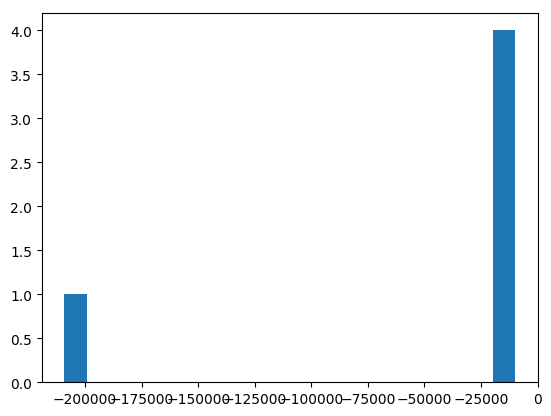

In [14]:
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
plt.hist(test_rewards_list, bins = 20)
plt.show()

In [15]:
# Visualizing test simulation:

# test_anim = ut.create_system_animation(test_visualization_steps, test_episodes * episode_length,test_freq)
# HTML(test_anim.to_html5_video())


/home/user/envs/rl/lib/python3.5/site-packages/pandas/core/series.py:841: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


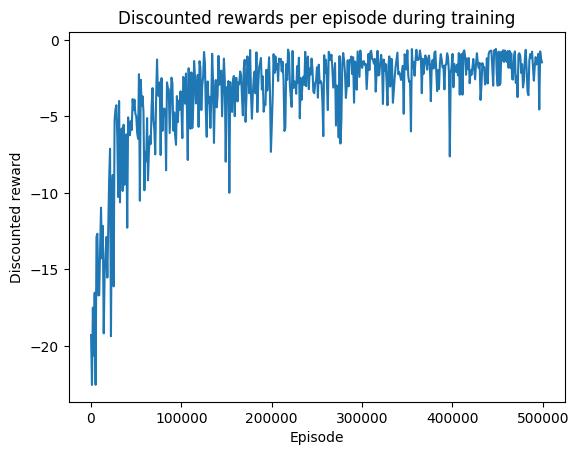

In [16]:
# Visualizing train simulation:

# episode =episodes
#simulation_id = 2
# step = 30
# discrewards_list = ut.load_obj(simulation_directory+"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")

# discrewards_list2 = [discrewards_list[i] for i in range(0,len(discrewards_list),step)]

# p = plt.plot([i for i in range(0,len(discrewards_list),step)], 
#              discrewards_list2)
# plt.savefig(simulation_directory+'/discrewards-sim' + f'{simulation_id}' + '.png')

discrewards = pd.read_table(rewards_file, sep = ",")

indices = [i for i in range(0,episodes,10)]

plt.plot(discrewards['episode'][indices],discrewards['discreward'][indices], label = "Discounted rewards")
plt.title("Discounted rewards per episode during training")
plt.xlabel("Episode")
plt.ylabel("Discounted reward")
plt.savefig(simulation_directory + '/discounted-rewards-sim' + '{}'.format(simulation_id) + '.pdf')

plt.show()
plt.close()


### Test visualization

In [17]:
def visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory,
                        level_counts_list):
    test_states = pd.read_table(states_file, sep = ",")
    test_states.head()


    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    lvl_colors = ["Orange", "Green","Orange"]

    tanks = test_toy_system.tanks
    
    def my_indicator(x_min, x, x_max):
            if (x> x_min) & (x<=x_max):
                return 1
            else: 
                return 0
    def is_empty(x):
        if x <=0:
            return 1
        else: 
            return 0
        
    for i, color in enumerate(colors, start=1):    
        plt.subplot(2,3,i)
        states = test_states['stock{}'.format(i-1)]
        plt.plot(test_states['step'],states, label = "Shop {}".format(i-1), color = "Black")
        plt.title("Shop {}".format(i-1))

        plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
        for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
            plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                        linestyle = '--')
        plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


        percentages = tanks[i-1].level_percentages           
        c = percentages[1]
        e = percentages[2]          
        d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
        plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                    linestyle = '-.')

        plt.axhline(y= np.mean(states), xmin=0, xmax=episode_length, hold=None, 
                    color = "blue", linestyle = '-.')
        plt.xticks(range(0,episode_length+1,5))
        ##################### Count number of times the system is in (0,b), (b,c),(c,e),(e,1) ##########
        b = percentages[0]
        level_counts = np.zeros(5, dtype = np.int64)
        
        x_mins = np.array([0,b,c,e])*tanks[i-1].max_load
        x_maxs = np.array([b,c,e,1])*tanks[i-1].max_load

        for x in states:
            level_counts[0] = level_counts[0] + is_empty(x)
            for j in range(1,5):
                level_counts[j] = level_counts[j] + my_indicator(x_mins[j-1], x, x_maxs[j-1])
            
        level_counts_list.append(level_counts)



    plt.subplot(2,3,6)
    plt.title("Legend")
    plt.axis('off')

    #plt.legend(bbox_to_anchor=(0.5 ,0.8), loc=2, borderaxespad=0.)
    plt.yticks([])
    plt.xticks([])

    patch1 = mpatches.Patch(color='red', label='Max/Min capacities', linestyle = '--', fill = False, linewidth = 2)
    patch2 = mpatches.Patch(color='orange', label='Max/Min levels', linestyle = '--', fill = False, linewidth = 2)
    patch3 = mpatches.Patch(color='green', label='Danger level', linestyle = '--', fill = False, linewidth = 2)
    patch4 = mpatches.Patch(color='lawngreen', label='Max reward level (M)', linestyle = '-.', fill = False, linewidth = 2)
    patch5 = mpatches.Patch(color='blue', label='Observed mean level', linestyle = '-.', fill = False, linewidth = 2)
    patch6 = mpatches.Patch(color='black', label='Current stock level', linestyle = '-', fill = False, linewidth = 2)


    plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6], loc = 'center')

    plt.tight_layout() 
    plt.savefig(simulation_directory + '/tank-levels-sim' + '{}'.format(simulation_id) + '.pdf')
    plt.show()
    plt.close()


## Simulations

In [20]:

def test_simulation(simulation_id,
                   max_episodes,
                   n_episodes = 1,
                   noise = False):
    
    # Initialize directories and files
    
    simulation_directory = './simulations/simulation{}'.format(simulation_id)
    rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
    states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing
    
    with open(states_file,'w') as f:
         np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',') 

    # Initialize system
    episodes = max_episodes#100000

    tanks, trucks, graph, weights_matrix = initialize_test_system(noise, seed =episodes+1)
    test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

    Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episodes))


    test_episodes = n_episodes
    episode_length =30
    test_freq = 1
    test_verbose = False

    test_visualization_steps = []
    test_rewards_list = []
    test_level_rewards_list = []
    test_transport_rewards_list = []
    test_trucks_sent_list = []
    test_number_of_first_trucks_sent_list = []
    test_number_of_second_trucks_sent_list = []
    test_number_of_trucks_not_deliverying_list = []
    
    test_level_counts_list = []
    
        
    test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           number_of_first_trucks_sent_list = test_number_of_first_trucks_sent_list,           
           number_of_second_trucks_sent_list=test_number_of_second_trucks_sent_list, 
           number_of_trucks_not_deliverying_list = test_number_of_trucks_not_deliverying_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q 
          )
            
    visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory,
                        test_level_counts_list)   
    print("Total discounted rewards","Level rewards", "Transport rewards")
    print(sum(test_rewards_list)/n_episodes, sum(test_level_rewards_list)/n_episodes,sum(test_transport_rewards_list)/n_episodes )
    print("Average trucks sent: ", sum(test_trucks_sent_list)/n_episodes)

    #     if n_episodes == 1:
    first_type = sum(test_number_of_first_trucks_sent_list)/n_episodes
    print("Average 1st type Trucks sent to each shop:", first_type)
    print("Average 1st type Trucks sent:", sum(first_type[0:n] ) )

    second_type = sum(test_number_of_second_trucks_sent_list)/n_episodes
    print("Average 2nd type Trucks sent to each shop:", second_type)
    print("Average 2nd type Trucks sent:",  sum(second_type[0:n] ))

    print("Average number of trucks not deliverying:", sum(test_number_of_trucks_not_deliverying_list)/n_episodes )

    for i in range(n):
            print("Average level counts for shop {}:".format(i), test_level_counts_list[i]/n_episodes )


    print("Average total level counts:", sum(test_level_counts_list)/n_episodes )
    print("Percentage total level counts:", (sum(test_level_counts_list)/n_episodes)/(episode_length * n) * 100 )

    
test_episodes = 10

### Deterministic consumption rates without transport/unload costs, 0.5M episodes 

Test episode: 1
Episode 1 t 0 -1333.8216445 -1333.8216445 0.0 5500
Episode 1 t 1 -498.4153942 -498.4153942 0.0 5500
Episode 1 t 2 -858.0806194 -294.7068994 563.37372 4500
Episode 1 t 3 -550.7873265 -435.2234865 115.56384 0500
Episode 1 t 4 -1598.6972709 32.6101491 1631.30742 2400
Episode 1 t 5 27.1089953 27.1089953 0.0 5500
Episode 1 t 6 -158.7456652 -158.7456652 0.0 5500
Episode 1 t 7 -1359.9648467 -1359.9648467 0.0 5500
Episode 1 t 8 -2425.5047502 -1263.6754302 1161.82932 0400
Episode 1 t 9 -1458.2569894 -411.9915094 1046.26548 5300
Episode 1 t 10 -1079.0829594 -32.8174794 1046.26548 5300
Episode 1 t 11 -3020.7177934 -1389.4103734 1631.30742 2300
Episode 1 t 12 -1416.4277954 -254.5984754 1161.82932 0400
Episode 1 t 13 -1026.0563073 20.2091727 1046.26548 5300
Episode 1 t 14 -1611.9929139 -2.3537139 1609.6392 3300
Episode 1 t 15 -1990.0195317 -1415.8117017 574.20783 1500
Episode 1 t 16 -1526.946383 -365.117063 1161.82932 0400
Episode 1 t 17 -1611.7756939 19.5317261 1631.30742 2300
Epis

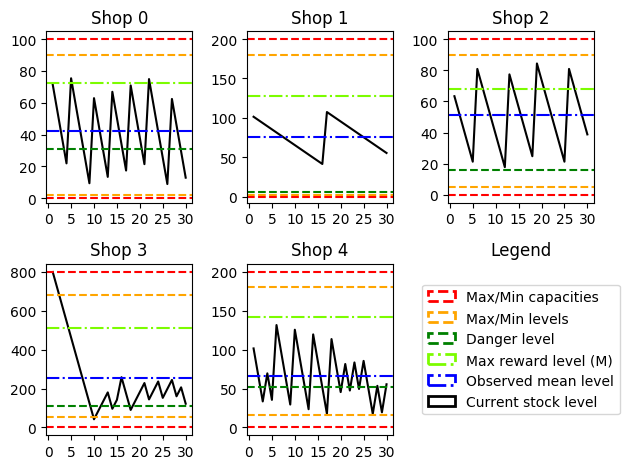

Total discounted rewards Level rewards Transport rewards
-11035.291733177246 -13987.240387598127 26499.717149999997
Average trucks sent:  37.0
Average 1st type Trucks sent to each shop: [ 7.  1.  4.  1.  6. 11.]
Average 1st type Trucks sent: 19.0
Average 2nd type Trucks sent to each shop: [ 0.  0.  0. 14.  4. 12.]
Average 2nd type Trucks sent: 18.0
Average number of trucks not deliverying: 0.0
Average level counts for shop 0: [ 0.  0. 11. 19.  0.]
Average level counts for shop 1: [ 0.  0.  0. 30.  0.]
Average level counts for shop 2: [ 0.  0.  0. 30.  0.]
Average level counts for shop 3: [ 0.  1.  3. 24.  2.]
Average level counts for shop 4: [ 0.  0. 12. 18.  0.]
Average total level counts: [  0.   1.  26. 121.   2.]
Percentage total level counts: [ 0.          0.66666667 17.33333333 80.66666667  1.33333333]


In [19]:
test_simulation(simulation_id=simulation_id, max_episodes = 5*10**5,n_episodes = 1)

Test episode: 1
Test episode: 2
Test episode: 3
Test episode: 4
Some tank is in a forbidden level
Some tank is in a forbidden level
Test episode: 5
Test episode: 6
Some tank is in a forbidden level
Test episode: 7
Test episode: 8
Some tank is in a forbidden level
Test episode: 9
Test episode: 10
Some tank is in a forbidden level
Test episode: 11
Some tank is in a forbidden level
Some tank is in a forbidden level
Test episode: 12
Test episode: 13
Test episode: 14
Test episode: 15
Test episode: 16
Some tank is in a forbidden level
Some tank is in a forbidden level
Test episode: 17
Some tank is in a forbidden level
Test episode: 18
Some tank is in a forbidden level
Test episode: 19
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Test episode: 20
Some tank is in a forbidden level
Some tank is in a forbidden level
Test episode: 21
Some tank is in a forbidden level
Test episode: 22
Some tank is in a forbidden level
Test episode: 23
Some t

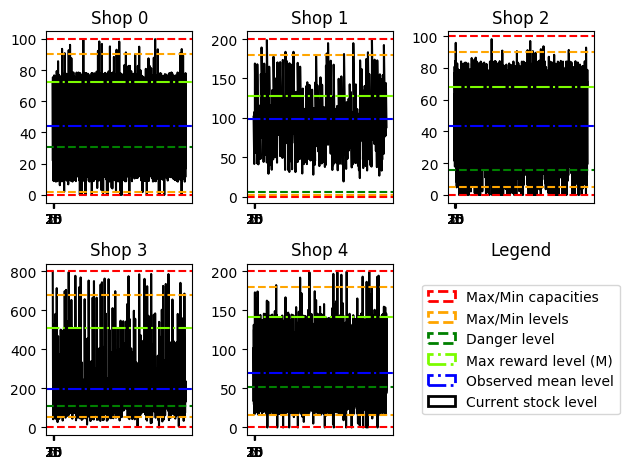

Total discounted rewards Level rewards Transport rewards
-231898.83354308945 -1033656.068379264 29009.856618599995
Average trucks sent:  39.16
Average 1st type Trucks sent to each shop: [ 6.73  0.99  4.28  0.59  6.16 11.25]
Average 1st type Trucks sent: 18.75
Average 2nd type Trucks sent to each shop: [ 0.    0.13  0.   16.24  4.04  9.59]
Average 2nd type Trucks sent: 20.409999999999997
Average number of trucks not deliverying: 0.03
Average level counts for shop 0: [ 0.14  0.03  9.29 20.35  0.19]
Average level counts for shop 1: [ 0.   0.   0.  29.7  0.3]
Average level counts for shop 2: [ 0.64  0.51  2.07 26.67  0.11]
Average level counts for shop 3: [1.000e-02 7.800e-01 2.950e+00 2.593e+01 3.300e-01]
Average level counts for shop 4: [ 0.14  0.1  10.69 18.95  0.12]
Average total level counts: [  0.93   1.42  25.   121.6    1.05]
Percentage total level counts: [ 0.62        0.94666667 16.66666667 81.06666667  0.7       ]


In [21]:
test_simulation(simulation_id=simulation_id, max_episodes = 5*10**5,n_episodes = 100)
